# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Extracting ./cs231n/datasets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\t10k-labels-idx1-ubyte.gz


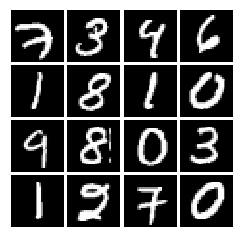

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(x, 0) + alpha * tf.minimum(x, 0)


Test your leaky ReLU implementation. You should get errors < 1e-10

In [4]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [5]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_uniform([batch_size, dim], minval=-1, maxval=1)


Make sure noise is the correct shape and type:

In [6]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [7]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        dense1 = tf.layers.dense(inputs=x, units=256, activation=leaky_relu)
        
        dense2 = tf.layers.dense(inputs=dense1, units=256, activation=leaky_relu)
        
        logits = tf.layers.dense(inputs=dense2, units=1)
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [8]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [9]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        dense1 = tf.layers.dense(z, units=1024, activation=tf.nn.relu)

        dense2 = tf.layers.dense(dense1, units=1024, activation=tf.nn.relu)
        
        dense3 = tf.layers.dense(dense2, units=784)
        
        img = tf.tanh(dense3)
        
        return img

Test to make sure the number of parameters in the generator is correct:

In [10]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [11]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    G_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_fake, labels = tf.ones_like(logits_fake))
    G_loss = tf.reduce_mean(G_loss)
    D_loss1 = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_real, labels = tf.ones_like(logits_real))
    D_loss2 = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits_fake, labels = tf.zeros_like(logits_fake))
    D_loss = tf.reduce_mean(D_loss1 + D_loss2)
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [12]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 1.20519e-16
Maximum error in g_loss: 7.19722e-17


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [13]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate, beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate, beta1)
    pass
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [14]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [15]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

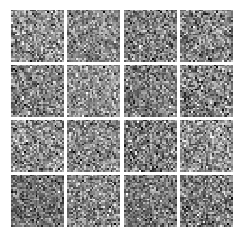


Iter: 0, D: 1.352, G:0.6759
Iter: 50, D: 0.36, G:1.411
Iter: 100, D: 1.047, G:1.913
Iter: 150, D: 1.618, G:1.663
Iter: 200, D: 2.027, G:0.6505


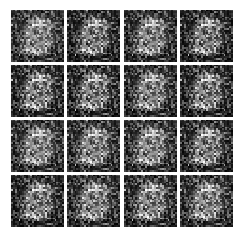


Iter: 250, D: 1.169, G:1.165
Iter: 300, D: 1.922, G:1.753
Iter: 350, D: 0.8844, G:1.779
Iter: 400, D: 1.992, G:0.7508
Iter: 450, D: 3.603, G:0.3717


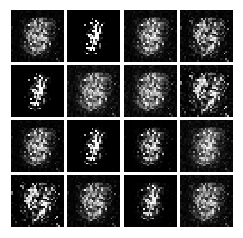


Iter: 500, D: 1.243, G:1.012
Iter: 550, D: 1.108, G:1.286
Iter: 600, D: 1.003, G:1.729
Iter: 650, D: 0.9768, G:2.158
Iter: 700, D: 0.906, G:1.914


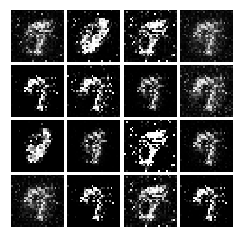


Iter: 750, D: 1.103, G:1.591
Iter: 800, D: 1.319, G:0.9798
Iter: 850, D: 1.067, G:1.307
Iter: 900, D: 1.057, G:1.655
Iter: 950, D: 0.9713, G:1.847


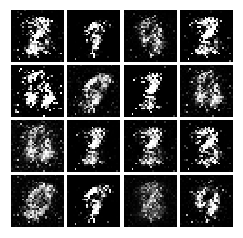


Iter: 1000, D: 1.3, G:2.47
Iter: 1050, D: 1.252, G:0.6553
Iter: 1100, D: 1.024, G:1.748
Iter: 1150, D: 1.092, G:1.186
Iter: 1200, D: 1.534, G:1.257


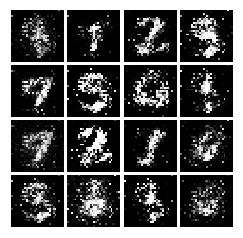


Iter: 1250, D: 1.271, G:0.9947
Iter: 1300, D: 1.183, G:1.292
Iter: 1350, D: 1.006, G:0.7443
Iter: 1400, D: 1.345, G:1.071
Iter: 1450, D: 1.244, G:0.8696


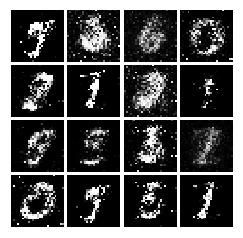


Iter: 1500, D: 1.257, G:1.887
Iter: 1550, D: 1.267, G:1.662
Iter: 1600, D: 1.15, G:1.07
Iter: 1650, D: 1.223, G:0.979
Iter: 1700, D: 1.385, G:0.8185


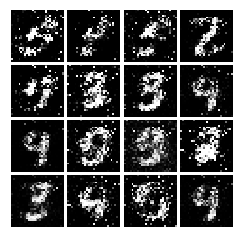


Iter: 1750, D: 1.262, G:1.293
Iter: 1800, D: 1.168, G:0.8656
Iter: 1850, D: 1.282, G:0.9368
Iter: 1900, D: 1.336, G:0.9033
Iter: 1950, D: 1.185, G:1.023


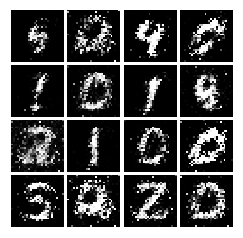


Iter: 2000, D: 1.362, G:0.7734
Iter: 2050, D: 1.362, G:0.9076
Iter: 2100, D: 1.274, G:0.9186
Iter: 2150, D: 1.651, G:1.207
Iter: 2200, D: 1.192, G:1.015


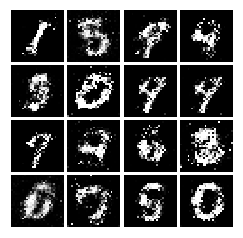


Iter: 2250, D: 1.279, G:0.8443
Iter: 2300, D: 1.318, G:0.8079
Iter: 2350, D: 1.271, G:0.8165
Iter: 2400, D: 1.222, G:0.8879
Iter: 2450, D: 1.25, G:0.8475


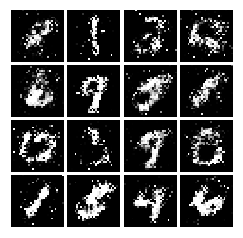


Iter: 2500, D: 1.262, G:0.8666
Iter: 2550, D: 1.382, G:0.8599
Iter: 2600, D: 1.214, G:1.058
Iter: 2650, D: 1.321, G:0.8826
Iter: 2700, D: 1.394, G:0.7226


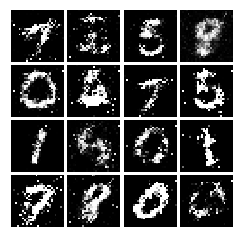


Iter: 2750, D: 1.305, G:0.8225
Iter: 2800, D: 1.338, G:0.8438
Iter: 2850, D: 1.372, G:0.7858
Iter: 2900, D: 1.346, G:0.8159
Iter: 2950, D: 1.365, G:0.7491


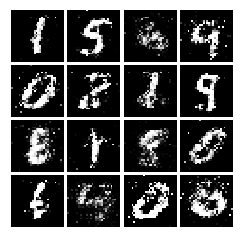


Iter: 3000, D: 1.3, G:0.8454
Iter: 3050, D: 1.348, G:0.8127
Iter: 3100, D: 1.368, G:0.8433
Iter: 3150, D: 1.311, G:0.8639
Iter: 3200, D: 1.34, G:0.7845


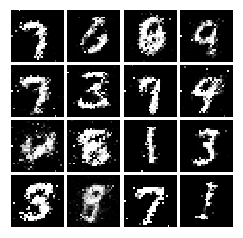


Iter: 3250, D: 1.296, G:0.8397
Iter: 3300, D: 1.289, G:0.8412
Iter: 3350, D: 1.36, G:0.8924
Iter: 3400, D: 1.349, G:0.8353
Iter: 3450, D: 1.321, G:0.8077


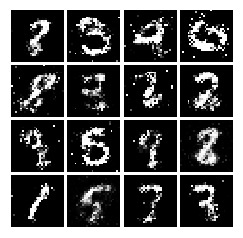


Iter: 3500, D: 1.295, G:0.8596
Iter: 3550, D: 1.292, G:0.9058
Iter: 3600, D: 1.273, G:0.8068
Iter: 3650, D: 1.311, G:0.8339
Iter: 3700, D: 1.256, G:0.8317


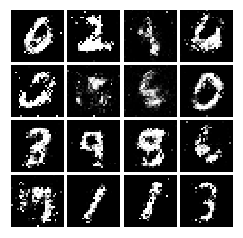


Iter: 3750, D: 1.307, G:0.8318
Iter: 3800, D: 1.293, G:0.7966
Iter: 3850, D: 1.281, G:0.827
Iter: 3900, D: 1.247, G:0.8639
Iter: 3950, D: 1.287, G:0.7741


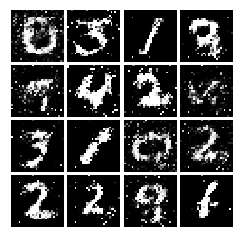


Iter: 4000, D: 1.29, G:0.9389
Iter: 4050, D: 1.299, G:0.7779
Iter: 4100, D: 1.291, G:1.089
Iter: 4150, D: 1.377, G:0.7961
Iter: 4200, D: 1.306, G:0.9335


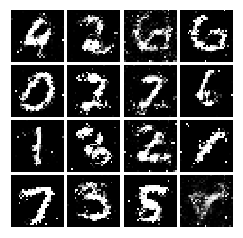


Iter: 4250, D: 1.373, G:0.742
Final images


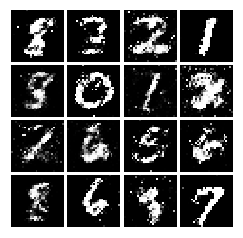

In [16]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [17]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss

    G_loss = 0.5*tf.reduce_mean(tf.subtract(score_fake, 1)**2)
    D_loss1 = 0.5*tf.reduce_mean(tf.subtract(score_real, 1)**2)
    D_loss2 = 0.5*tf.reduce_mean(score_fake**2)

    D_loss = D_loss1 + D_loss2
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [18]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [19]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

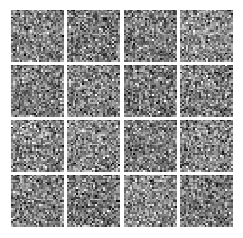


Iter: 0, D: 1.95, G:0.3442
Iter: 50, D: 0.01355, G:0.6211
Iter: 100, D: 0.01801, G:0.6026
Iter: 150, D: 0.3987, G:0.05937
Iter: 200, D: 0.1932, G:1.142


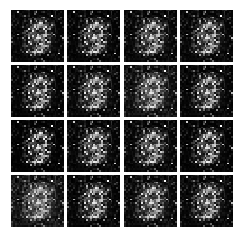


Iter: 250, D: 0.1264, G:0.3002
Iter: 300, D: 0.09222, G:0.2862
Iter: 350, D: 0.08829, G:0.5455
Iter: 400, D: 0.1452, G:0.3763
Iter: 450, D: 0.0892, G:0.3061


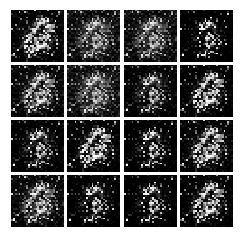


Iter: 500, D: 0.1403, G:0.571
Iter: 550, D: 0.05005, G:0.6496
Iter: 600, D: 0.2088, G:0.9179
Iter: 650, D: 0.3875, G:0.4477
Iter: 700, D: 0.1935, G:0.2875


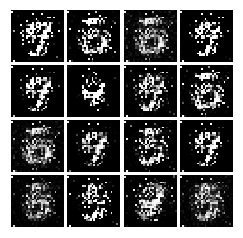


Iter: 750, D: 0.1459, G:0.3024
Iter: 800, D: 0.2696, G:0.6177
Iter: 850, D: 0.08348, G:0.7909
Iter: 900, D: 0.4732, G:0.5712
Iter: 950, D: 0.2721, G:1.554


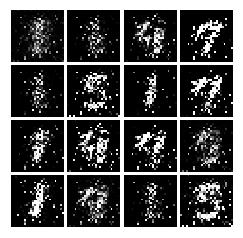


Iter: 1000, D: 0.2347, G:0.4229
Iter: 1050, D: 0.08633, G:0.4824
Iter: 1100, D: 0.09857, G:0.4268
Iter: 1150, D: 0.1725, G:0.3305
Iter: 1200, D: 0.1971, G:0.2945


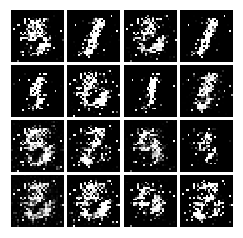


Iter: 1250, D: 0.1095, G:0.4303
Iter: 1300, D: 0.1264, G:0.2032
Iter: 1350, D: 0.1542, G:0.2901
Iter: 1400, D: 0.4174, G:0.4616
Iter: 1450, D: 0.1753, G:0.3908


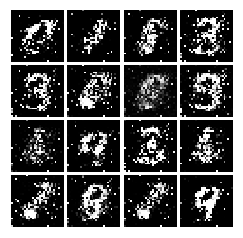


Iter: 1500, D: 0.1739, G:0.2662
Iter: 1550, D: 0.1589, G:0.2567
Iter: 1600, D: 0.1502, G:0.2688
Iter: 1650, D: 0.1564, G:0.2646
Iter: 1700, D: 0.175, G:0.2325


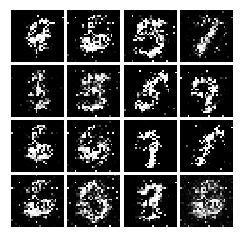


Iter: 1750, D: 0.1862, G:0.0796
Iter: 1800, D: 0.1598, G:0.2663
Iter: 1850, D: 0.201, G:0.2187
Iter: 1900, D: 0.1819, G:0.2789
Iter: 1950, D: 0.214, G:0.2648


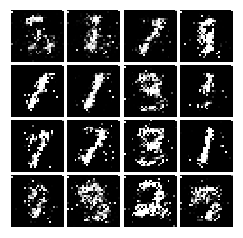


Iter: 2000, D: 0.3841, G:0.1307
Iter: 2050, D: 0.1987, G:0.3076
Iter: 2100, D: 0.2253, G:0.2071
Iter: 2150, D: 0.2172, G:0.1926
Iter: 2200, D: 0.2039, G:0.1886


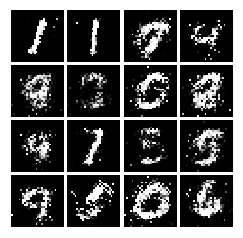


Iter: 2250, D: 0.216, G:0.1756
Iter: 2300, D: 0.2011, G:0.1931
Iter: 2350, D: 0.2337, G:0.2195
Iter: 2400, D: 0.2201, G:0.1804
Iter: 2450, D: 0.2285, G:0.1982


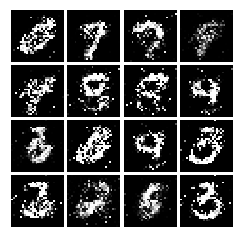


Iter: 2500, D: 0.224, G:0.1989
Iter: 2550, D: 0.2138, G:0.1607
Iter: 2600, D: 0.2323, G:0.1646
Iter: 2650, D: 0.2261, G:0.2028
Iter: 2700, D: 0.2219, G:0.1965


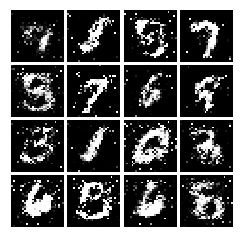


Iter: 2750, D: 0.2169, G:0.2004
Iter: 2800, D: 0.2346, G:0.183
Iter: 2850, D: 0.228, G:0.1696
Iter: 2900, D: 0.234, G:0.1802
Iter: 2950, D: 0.239, G:0.1805


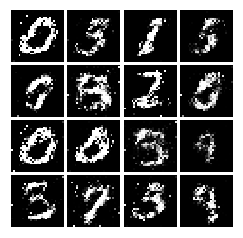


Iter: 3000, D: 0.2309, G:0.191
Iter: 3050, D: 0.2092, G:0.1821
Iter: 3100, D: 0.2282, G:0.2099
Iter: 3150, D: 0.2168, G:0.1641
Iter: 3200, D: 0.2151, G:0.1981


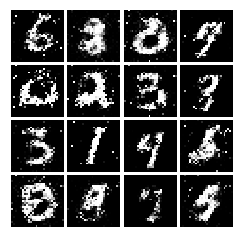


Iter: 3250, D: 0.2187, G:0.1602
Iter: 3300, D: 0.2386, G:0.1853
Iter: 3350, D: 0.2391, G:0.1761
Iter: 3400, D: 0.1944, G:0.1575
Iter: 3450, D: 0.2174, G:0.1621


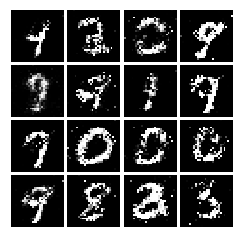


Iter: 3500, D: 0.2121, G:0.1896
Iter: 3550, D: 0.2484, G:0.1714
Iter: 3600, D: 0.2092, G:0.1883
Iter: 3650, D: 0.2175, G:0.176
Iter: 3700, D: 0.2376, G:0.1791


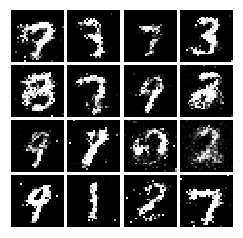


Iter: 3750, D: 0.2119, G:0.1679
Iter: 3800, D: 0.2237, G:0.186
Iter: 3850, D: 0.2226, G:0.1789
Iter: 3900, D: 0.2348, G:0.1785
Iter: 3950, D: 0.2193, G:0.1735


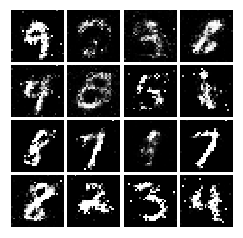


Iter: 4000, D: 0.2163, G:0.1722
Iter: 4050, D: 0.2356, G:0.1736
Iter: 4100, D: 0.2286, G:0.1542
Iter: 4150, D: 0.2175, G:0.1736
Iter: 4200, D: 0.221, G:0.1635


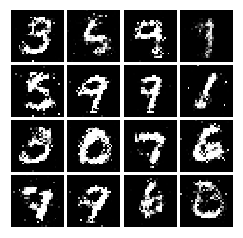


Iter: 4250, D: 0.2298, G:0.1594
Final images


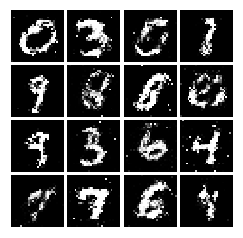

In [20]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

** (Write Your Answer In This Cell) **

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [21]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        # padding 'VALID' in conv results ceil((input_width - kernel_width + 1)/stride in width)
        
        feature = tf.reshape(x, [-1, 28, 28, 1])
        
        # 28x28 -> 24x24 (conv)-> 12x12 (pool)
        conv1 = tf.layers.conv2d(inputs=feature, filters=32, kernel_size=[5, 5], activation=leaky_relu)
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

        # 12x12 -> 8x8 (conv) -> 4x4 (pool)
        conv2 = tf.layers.conv2d(inputs=pool1, filters=64, kernel_size=[5, 5], activation=leaky_relu)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

        pool2_flat = tf.reshape(pool2, [-1, 4*4*64])
        dense3 = tf.layers.dense(inputs=pool2_flat, units=4*4*64, activation=leaky_relu)
        
        logits = tf.layers.dense(inputs=dense3, units=1)
        
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [22]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        dense1 = tf.layers.dense(inputs=z, units=4*4*64, activation=leaky_relu)
        bnorm1 = tf.layers.batch_normalization(dense1,training = True)
        
        dense2 = tf.layers.dense(inputs=bnorm1, units=7*7*128, activation=leaky_relu)
        bnorm2 = tf.layers.batch_normalization(dense2,training = True)
        
        feature = tf.reshape(bnorm2, [-1,7,7,128])
        convt3 = tf.layers.conv2d_transpose(inputs=feature, filters=64, kernel_size=[4,4], 
                                            strides=[2,2], padding='SAME', activation=tf.nn.relu)
        bnorm3 = tf.layers.batch_normalization(convt3,training = True)
        
        convt4 = tf.layers.conv2d_transpose(inputs=bnorm3, filters=1, kernel_size=[4,4], 
                                            strides=[2,2], padding='SAME', activation=tf.tanh)
        
        img = tf.reshape(convt4, [-1, 784])
        return img
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [23]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

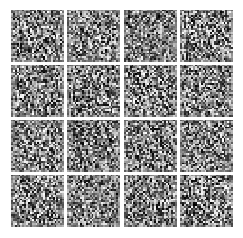


Iter: 0, D: 1.405, G:0.7964
Iter: 50, D: 0.9289, G:0.8892
Iter: 100, D: 0.8556, G:3.111
Iter: 150, D: 0.9836, G:1.381
Iter: 200, D: 1.22, G:0.9331


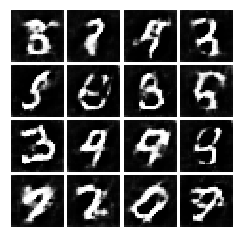


Iter: 250, D: 1.189, G:0.7695
Iter: 300, D: 1.12, G:1.09
Iter: 350, D: 1.245, G:1.2
Iter: 400, D: 1.077, G:0.9449
Iter: 450, D: 1.048, G:0.8441


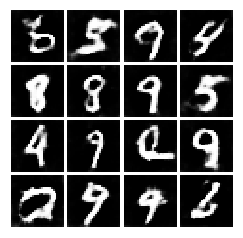


Iter: 500, D: 1.058, G:1.214
Iter: 550, D: 1.141, G:1.064
Iter: 600, D: 1.129, G:1.174
Iter: 650, D: 1.099, G:0.8707
Iter: 700, D: 1.117, G:0.7391


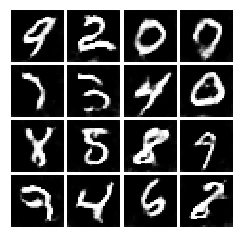


Iter: 750, D: 1.146, G:1.1
Iter: 800, D: 1.149, G:0.9718
Iter: 850, D: 1.177, G:0.9201
Iter: 900, D: 1.104, G:0.9814
Iter: 950, D: 1.554, G:0.8996


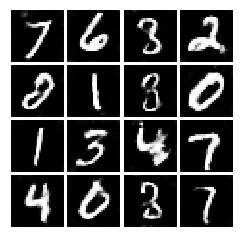


Iter: 1000, D: 1.178, G:0.9923
Iter: 1050, D: 1.171, G:1.202
Iter: 1100, D: 1.845, G:0.9863
Iter: 1150, D: 1.278, G:0.7087
Iter: 1200, D: 1.161, G:1.154


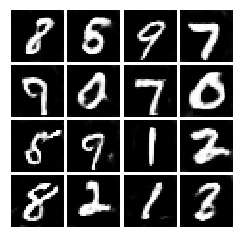


Iter: 1250, D: 1.094, G:0.9834
Iter: 1300, D: 1.077, G:1.419
Iter: 1350, D: 1.047, G:1.114
Iter: 1400, D: 1.095, G:1.018
Iter: 1450, D: 1.106, G:0.9931


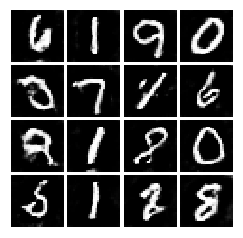


Iter: 1500, D: 1.142, G:0.929
Iter: 1550, D: 1.119, G:0.9902
Iter: 1600, D: 1.119, G:0.8461
Iter: 1650, D: 1.086, G:0.8693
Iter: 1700, D: 1.132, G:0.8344


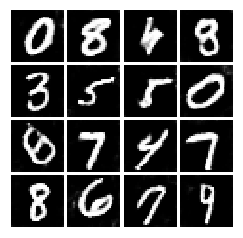


Iter: 1750, D: 1.122, G:1.14
Iter: 1800, D: 1.138, G:0.6225
Iter: 1850, D: 1.106, G:1.207
Iter: 1900, D: 1.204, G:0.6774
Iter: 1950, D: 1.07, G:0.9384


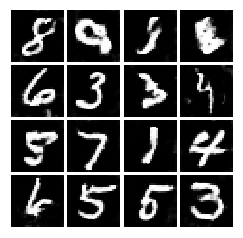


Iter: 2000, D: 1.058, G:1.203
Iter: 2050, D: 1.07, G:0.9098
Iter: 2100, D: 1.121, G:0.8823
Final images


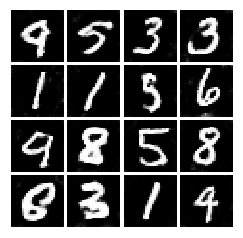

In [24]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)

# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

** (Write Your Answer In This Cell) **

------

# Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. They should converge to get credit.
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Demonstrate the value of GANs in building semi-supervised models. In a semi-supervised example, only some fraction of the input data has labels; we can supervise this in MNIST by only training on a few dozen or hundred labeled examples. This was first described in [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498).
* Something new/cool.

#### Describe what you did here

# WGAN-GP (Small Extra Credit)

Please only attempt after you have completed everything above.

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

In [27]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        # TODO: implement architecture
        feature = tf.reshape(x, [-1, 28, 28, 1])
        
        # 13x13 (float(28-4+1)/2 in 'valid' padding
        conv1 = tf.layers.conv2d(inputs=feature, filters=64, kernel_size=[4, 4], 
                                 strides=[2,2], activation=leaky_relu)
         
        # 5x5
        conv2 = tf.layers.conv2d(inputs=conv1, filters=128, kernel_size=[4, 4], 
                                 strides=[2,2], activation=leaky_relu)
        bnorm2 = tf.layers.batch_normalization(conv2,training = True)
        pool2_flat = tf.reshape(bnorm2, [-1, 5*5*128])
        
        dense3 = tf.layers.dense(inputs=pool2_flat, units=1024, activation=leaky_relu)        
        logits = tf.layers.dense(inputs=dense3, units=1)
        
        return logits
test_discriminator(3411649)

Correct number of parameters in discriminator.


In [28]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [60]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    # This implementation is not equipped 'n_{critic}' which exists in the original paper.
    D_loss = None
    G_loss = None

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform([tf.shape(x)[0], 1], 0.0, 1.0)
    x_hat = eps * x + (1-eps) * G_sample

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        logits_hat = discriminator(x_hat)        
        grad_D_x_hat = tf.gradients(logits_hat, [x_hat])[0]

    grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grad_D_x_hat), axis=[1]))
    grad_pen = tf.reduce_mean((grad_norm-1.0)**2)

    D_loss = tf.reduce_mean(logits_fake) - tf.reduce_mean(logits_real) + lam * grad_pen
    G_loss = -tf.reduce_mean(logits_fake)

    print('grad_D_x_hat', grad_D_x_hat.shape, tf.shape(grad_D_x_hat))

    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

grad_D_x_hat (128, 784) Tensor("Shape_15:0", shape=(2,), dtype=int32)


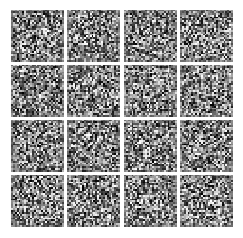


Iter: 0, D: 17.05, G:0.1912
Iter: 50, D: -2.462, G:-5.103
Iter: 100, D: -1.654, G:-0.7828
Iter: 150, D: -2.131, G:-3.849
Iter: 200, D: 0.5476, G:-2.727


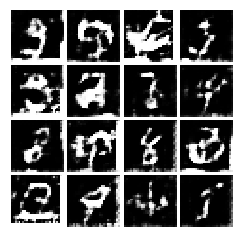


Iter: 250, D: -0.6004, G:-1.872
Iter: 300, D: 0.1342, G:1.848
Iter: 350, D: 0.2103, G:-1.912
Iter: 400, D: -0.4258, G:-2.394
Iter: 450, D: -0.1238, G:-1.303


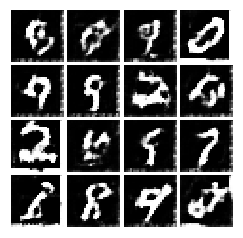


Iter: 500, D: -0.6895, G:-1.921
Iter: 550, D: -0.2481, G:0.7664
Iter: 600, D: -0.06606, G:-0.07962
Iter: 650, D: -1.572, G:-4.429
Iter: 700, D: -1.61, G:-6.309


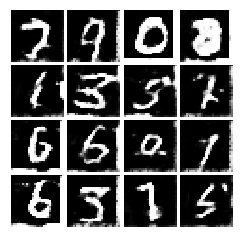


Iter: 750, D: 1.695, G:-0.1343
Iter: 800, D: -1.052, G:-6.277
Iter: 850, D: -1.665, G:-5.482
Iter: 900, D: -0.79, G:-6.99
Iter: 950, D: -2.772, G:-6.547


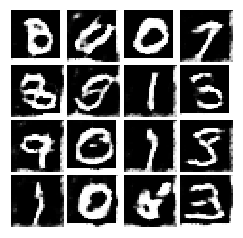


Iter: 1000, D: -0.5496, G:-0.06221
Iter: 1050, D: -0.2753, G:-3.698
Iter: 1100, D: -1.096, G:-3.101
Iter: 1150, D: -2.187, G:-1.248
Iter: 1200, D: -0.6773, G:-3.78


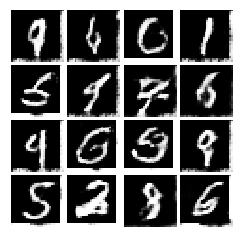


Iter: 1250, D: -1.599, G:-4.083
Iter: 1300, D: -2.544, G:-12.69
Iter: 1350, D: -2.452, G:-13.81
Iter: 1400, D: -1.368, G:-6.933
Iter: 1450, D: 0.671, G:-2.534


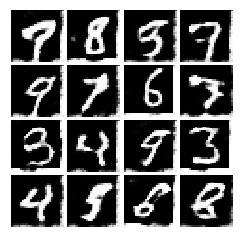


Iter: 1500, D: -0.1227, G:3.044
Iter: 1550, D: -0.2696, G:2.731
Iter: 1600, D: -0.3962, G:0.4496
Iter: 1650, D: 0.03444, G:3.045
Iter: 1700, D: -0.06973, G:0.9242


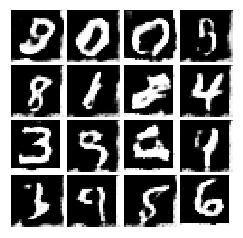


Iter: 1750, D: -0.3902, G:3.782
Iter: 1800, D: 0.5332, G:-2.021
Iter: 1850, D: -0.2468, G:2.928
Iter: 1900, D: 0.1668, G:-1.967
Iter: 1950, D: 0.495, G:-0.09014


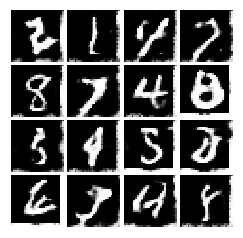


Iter: 2000, D: 0.4348, G:-0.4473
Iter: 2050, D: 0.761, G:-0.5628
Iter: 2100, D: 0.7803, G:-1.667
Final images


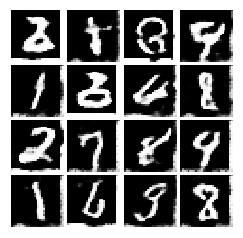

In [61]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=5)